In [2]:
%load_ext autoreload   
%autoreload 2
%matplotlib inline

import os
import sys
os.chdir('../../')
from blp import blp
import pandas as pd
from pandas.tseries.offsets import BDay
import seaborn as sns
import hydrogen.dateutils
from hydrogen.instrument import Future

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
C:\Users\yowtzu\repo\hydrogen


In [3]:
#historical_trading_dates = pd.Series(df.index)
z_future = Future('Z 1 Index')
calendar = pd.read_csv('data/static.csv')
calendar.FUT_NOTICE_FIRST = pd.to_datetime(calendar.FUT_NOTICE_FIRST)
calendar = calendar[calendar.TICKER.isin(z_future.ticker_list())][["TICKER", "FUT_NOTICE_FIRST"]]
calendar = calendar.rename(columns={'FUT_NOTICE_FIRST':'ROLL_DATE'})
calendar['START_DATE'] = calendar.ROLL_DATE.shift(1)
calendar['END_DATE'] = calendar.ROLL_DATE.apply(
    lambda x: x - BDay())
calendar['NEXT_TICKER'] = calendar.TICKER.shift(-1)
calendar.START_DATE = calendar.START_DATE.fillna(pd.tslib.Timestamp.min)
calendar.NEXT_TICKER = calendar.NEXT_TICKER.fillna("")
calendar.tail()
#    lambda x: hydrogen.dateutils.nearest_date_before(trading_dates, x))

,TICKER,ROLL_DATE,START_DATE,END_DATE,NEXT_TICKER
336,Z H6 Index,2016-03-18,2015-12-18,2016-03-17,Z M6 Index
337,Z M6 Index,2016-06-17,2016-03-18,2016-06-16,Z U6 Index
338,Z U6 Index,2016-09-16,2016-06-17,2016-09-15,Z Z6 Index
339,Z Z6 Index,2016-12-16,2016-09-16,2016-12-15,Z H7 Index
340,Z H7 Index,2017-03-17,2016-12-16,2017-03-16,


In [4]:
z_future = Future('Z 1 Index')

def read_ohlcv(ticker, start_date, end_date):
    res = pd.Series()
    
    filename = os.path.join('data', 'ohlcv', ticker+'.csv')
    if os.path.exists(filename):
        df = pd.read_csv(filename, index_col='DATE')
        df.index = pd.to_datetime(df.index)
        res = df.PX_LAST[start_date:end_date]
    return res

df_list = [ read_ohlcv(row.TICKER, row.START_DATE, row.END_DATE) for idx, row in calendar.iterrows() ]
df = pd.concat(df_list)

adj_list =  [ read_ohlcv(row.NEXT_TICKER, row.END_DATE, row.END_DATE) for idx, row in calendar.iterrows() ]

In [5]:
adj = pd.concat(adj_list)
adj = (adj - df.asof(adj.index))
(df + adj[::-1].cumsum()[::-1].reindex(df.index, method='bfill').fillna(0)).head()

DATE
2005-01-04    3970.5
2005-01-05    3943.0
2005-01-06    3951.0
2005-01-07    3980.5
2005-01-10    3966.0
dtype: float64

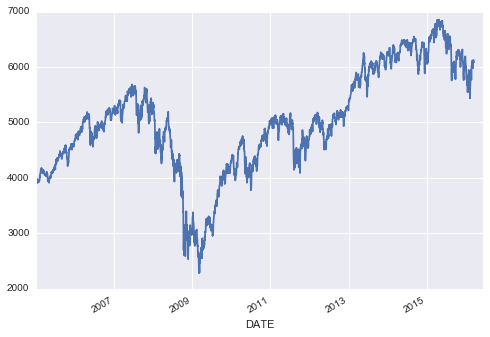

In [6]:
(df + adj[::-1].cumsum()[::-1].reindex(df.index, method='bfill')).plot()

In [14]:
adj = pd.concat(adj_list)
adj = (adj / df.asof(adj.index))
(df * adj[::-1].cumprod()[::-1].reindex(df.index, method='bfill').fillna(1)).head()

DATE
2005-01-04    4164.082371
2005-01-05    4140.395896
2005-01-06    4147.286507
2005-01-07    4172.695635
2005-01-10    4160.206402
dtype: float64

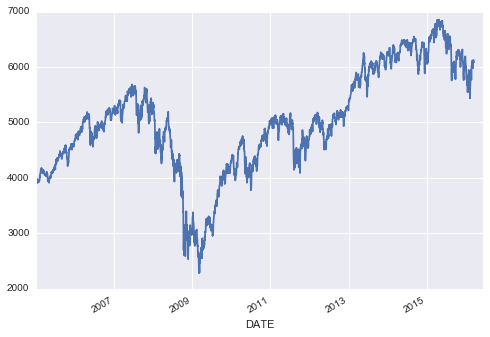

In [8]:
(df + adj[::-1].cumsum()[::-1].reindex(df.index, method='bfill')).plot()

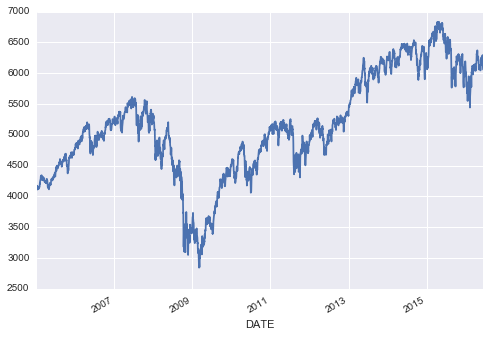

In [10]:
adj = pd.concat(adj_list)
adj = (adj / df.asof(adj.index))
(df * adj[::-1].cumprod()[::-1].reindex(df.index, method='bfill').fillna(1)).plot()